# Naive MLP to detect spam
Here: build the most basic solution that classifies emails.
We don't expect a good solution, just something that works so that we can implement changes later on, one at a time.

Naive ideas :
Word embedder : naive solution which consists of going through all the words in the file and assigning them the order in which they are encountered.
Classifier itself : MLP

It is also necessary to clean the data (transform to lowercase ...) but I describe that in detail later.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # conda install -c anaconda pandas

#Deep learning 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

#Text processing
import tensorflow as tf # conda install -c conda-forge tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Tokenizer
A tokenizer converts a string, such as a sentence, into individual tokens. These may be words or numbers. The simplest tokenizer consists in separating a sentence into words.

In [2]:
text = "Here’s to the crazy ones, the misfits, the rebels, the troublemakers"
text.split() # python method

['Here’s',
 'to',
 'the',
 'crazy',
 'ones,',
 'the',
 'misfits,',
 'the',
 'rebels,',
 'the',
 'troublemakers']

There are several details to take into account. For example, whether to include punctuation and how to handle upper case letters. The tokenizer method from tensorflow.keras allows us to transform text into sequences.

In [3]:
#Tensorflow.keras method
text2 = ["Here’s to the crazy ones, the misfits, the rebels, the troublemakers"]
        # LIST containing our string, not the same thing I don't know why
tokenizer = Tokenizer(num_words=50, lower=True, char_level=False)
tokenizer.fit_on_texts(text2) 
sequences = tokenizer.texts_to_sequences(text2)
print(sequences)

[[2, 3, 1, 4, 5, 1, 6, 1, 7, 1, 8]]


Let's examine each command.

*fit_on_texts* updates the vocabulary of our tokenizer. Each word is assigned an index based on how frequent it appears in our text. So the most common word gets assigned 1, the second most common 2 and so on. The index 0 is reserved for padding.

We can define a limit to the size of our vocabulary, defined in the first line with *num_word=50*, which can allow us to filter out rare words. The tokenizer method filters out all punctuation by default, and *lower=True* converts all uppercase characters to lowercase. Setting *char_level=False* simply means we split at the level of words rather than at the level of characters.

*texts_to_sequences* transforms the given text into a sequence of indices, using the internal vocabulary of our tokenizer. Having the two commands be separate allows us to "train" our vocabulary on one text and convert any new text we want.

In [4]:
tokenizer.word_index

{'the': 1,
 'here’s': 2,
 'to': 3,
 'crazy': 4,
 'ones': 5,
 'misfits': 6,
 'rebels': 7,
 'troublemakers': 8}

# Load the data
Following the tutorial on https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8 to get something started.

In [5]:
url = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/SMSSpamCollection" #Use the RAW one
messages = pd.read_csv(url, sep ='\t', names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:10])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls
339   ham                             Sorry, I'll call later
357  spam  Congratulations ur awarded 500 of CD vouchers ...
444   ham                             Sorry, I'll call later
533   ham                  Gudnite....tc...practice going on
655   ham                       Did u got that persons story


We have 5572 messages, 4825 of which are ham and 747 are spam. The dataset is **highly unbalanced, so we need to do something about it.**. We also have 403 duplicate messages.

There are many ways to handle unbalanced dataset, and it is worth exploring other ways than the one shown in the link. The author uses downsampling, which simply deletes observations from the class that is overrepresented.

In [8]:
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

In [9]:
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 704)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [10]:
msg_df = pd.concat([ham_msg_df, spam_msg_df])
msg_df.reset_index(drop=True)

,label,message
0,ham,Maybe?! Say hi to and find out if got his ca...
1,ham,Jos ask if u wana meet up?
2,ham,I dont know oh. Hopefully this month.
3,ham,"Dear Hero,i am leaving to qatar tonite for an ..."
4,ham,No that just means you have a fat head
...,...,...
1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...
1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
1491,spam,Had your contract mobile 11 Mnths? Latest Moto...
1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [11]:
msg_labels = (msg_df['label'].map({'ham': 0, 'spam': 1})).values
            # map creates a dataframe where we replace values
            # .values is to extract the values as an array
msg_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [12]:
len(msg_labels)

1494

In [13]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'],
                                                                  msg_labels,
                                                                  test_size=0.2,
                                                                  random_state=705)

In [14]:
print(train_msg)
print("\n")
print(train_labels)

5039    Thanks for being there for me just to talk to ...
1122    Do you want 750 anytime any network mins 150 t...
1751                           Got it..mail panren paru..
1376                              We're finally ready fyi
3906    Do you want a new video handset? 750 anytime a...
                              ...                        
3562    Text BANNEDUK to 89555 to see! cost 150p texto...
5537    Want explicit SEX in 30 secs? Ring 02073162414...
1952    Haha... Really oh no... How? Then will they de...
4432       2mro i am not coming to gym machan. Goodnight.
2808    December only! Had your mobile 11mths+? You ar...
Name: message, Length: 1195, dtype: object


[0 1 0 ... 0 0 1]


In [15]:
#Tokenizer : turn words into integers
oov_tok = "<OOV>" # What to replace words that are not in the vocabulary with
vocab_size = 500 # Maximum number of words for tokenizer

tokenizer = Tokenizer(num_words = vocab_size,
                      char_level=False, # Work words by word
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [16]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'is': 11,
 'now': 12,
 'and': 13,
 '2': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'have': 19,
 'ur': 20,
 'txt': 21,
 'me': 22,
 'from': 23,
 '4': 24,
 'of': 25,
 'are': 26,
 'text': 27,
 'with': 28,
 'it': 29,
 'this': 30,
 'get': 31,
 'mobile': 32,
 'just': 33,
 'stop': 34,
 'no': 35,
 'my': 36,
 'only': 37,
 'reply': 38,
 'claim': 39,
 'will': 40,
 'send': 41,
 'out': 42,
 'so': 43,
 'if': 44,
 'that': 45,
 'be': 46,
 'we': 47,
 'our': 48,
 'prize': 49,
 'www': 50,
 'can': 51,
 'do': 52,
 'not': 53,
 'at': 54,
 'cash': 55,
 'but': 56,
 'won': 57,
 '150p': 58,
 'new': 59,
 't': 60,
 'win': 61,
 'msg': 62,
 '1': 63,
 'please': 64,
 'phone': 65,
 '50': 66,
 'who': 67,
 'uk': 68,
 'week': 69,
 'urgent': 70,
 'go': 71,
 'all': 72,
 'nokia': 73,
 'tone': 74,
 "i'm": 75,
 'service': 76,
 'when': 77,
 'min': 78,
 'what': 79,
 'know': 80,
 'want': 81,
 'r': 82,
 'by': 83,
 'c

In [17]:
len(word_index) # Importance of setting a max size of vocabulary here

4194

In [18]:
# Sequencing and padding on training and testing 
max_len = 50 # Max number of tokens, used with truncating and padding
trunc_type = "post" # Truncates sequences of tokens that are longer than max_len, post=right side
padding_type = "post" # Pads AFTER (with post) if sequence is shorter than max_len

training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                               padding = padding_type, truncating = trunc_type)

In [19]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


I have to convert to torch tensors the data that I have

In [20]:
print(type(training_padded))
print(type(train_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
X_train = torch.from_numpy(training_padded).float()
X_test = torch.from_numpy(testing_padded).float()
Y_train = torch.from_numpy(train_labels).float()
Y_test = torch.from_numpy(test_labels).float()

In [22]:
print(type(X_train))
print(type(Y_train))
print(Y_train[0])

<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor(0.)


In [23]:
max_len # Number of input neurons

50

In [24]:
iters = 30

net = nn.Sequential(
    nn.Linear(max_len, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=.01)

loss_history = [] #Per epoch
accuracy_history = []
accuracy_test_history = []

for i in range(iters):
    proba_pred = net(X_train)  # forward pass
    proba_pred = proba_pred.squeeze(-1)  # transform the 1-element vectors into scalars

    optimizer.zero_grad() # reset the gradients to 0
    loss = criterion(proba_pred, Y_train)
    loss_history.append(loss.item()) # .item() to turn it into a python number
    loss.backward()  # obtain the gradients with respect to the loss
    optimizer.step()  # perform one step of gradient descent

    with torch.no_grad():
        Y_pred = proba_pred > 0.5  # Binary label
        accuracy = (Y_train == Y_pred).float().mean()
        accuracy_history.append(accuracy.item())
            
    with torch.no_grad():
        proba_pred_test = net(X_test)
        proba_pred_test = proba_pred_test.squeeze(-1)
        Y_pred_test = proba_pred_test > 0.5
        accuracy_test = (Y_test == Y_pred_test).float().mean()
        accuracy_test_history.append(accuracy_test.item())
    
    print("Iteration {iter} done".format(iter=i+1))
    print("Training accuracy is equal to {trainAcc}".format(trainAcc=accuracy_history[-1]))
    print("Testing accuracy is equal to {testAcc}".format(testAcc=accuracy_test))

Iteration 1 done
Training accuracy is equal to 0.4694560766220093
Testing accuracy is equal to 0.5183946490287781
Iteration 2 done
Training accuracy is equal to 0.5046024918556213
Testing accuracy is equal to 0.52173912525177
Iteration 3 done
Training accuracy is equal to 0.5087866187095642
Testing accuracy is equal to 0.695652186870575
Iteration 4 done
Training accuracy is equal to 0.701255202293396
Testing accuracy is equal to 0.692307710647583
Iteration 5 done
Training accuracy is equal to 0.671966552734375
Testing accuracy is equal to 0.6053511500358582
Iteration 6 done
Training accuracy is equal to 0.5966527462005615
Testing accuracy is equal to 0.6354514956474304
Iteration 7 done
Training accuracy is equal to 0.6326360106468201
Testing accuracy is equal to 0.7324414849281311
Iteration 8 done
Training accuracy is equal to 0.7146443724632263
Testing accuracy is equal to 0.782608687877655
Iteration 9 done
Training accuracy is equal to 0.760669469833374
Testing accuracy is equal to 0

Well, it seems to work and we have an instantaneous result.

Many things to try, such as :
1. Word embedding : the one we use has no reason to be good, we just order words by how often they appear, but it doesn't help us locate the words
2. How to handle unbalanced dataset : discarding so many observations is not a great idea, we could also adapt our criterion to evaluate model (instead of just error rate)
3. Another architecture for network
    1. Convolutional network (why does it work ?)
    2. LSTM or any sequential network architecture

# Word embedding : test

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding # keras.layers.embeddings marche pas 

Embedding, arguments : vocabulary size,
   number of dimensions m in the embedding space represented by the Embedding layer,
   the length n of each padded sequence
 
Flatten : flattens the 2D output into a 1D array suitable for input to a Dense layer

Dense layer : classifies the values emitted from the flatten layer, changing the number of neurons in the dense layer tends to maximize accuracy

In [63]:
vocab_size = 500
max_len = 50

model = Sequential()
model.add(Embedding(vocab_size, 32, input_length = max_len))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 32)            16000     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 221,057
Trainable params: 221,057
Non-trainable params: 0
_________________________________________________________________


If we only have a few hundred training samples, the embedding layer might not have enough information to properly vectorize the corpus of text. In that case, we can use pretrained word embeddings, but a network trained to classify text usually performs better when word embeddings are learned from the training data because such embeddings are task-specific. 

on va se servir de training_padded

In [64]:
hist = model.fit(training_padded, train_labels, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
48/48 [==============================] - 1s 8ms/step - loss: 0.4712 - accuracy: 0.7887 - val_loss: 0.2944 - val_accuracy: 0.8703
Epoch 2/5
48/48 [==============================] - 0s 3ms/step - loss: 0.2347 - accuracy: 0.9132 - val_loss: 0.1671 - val_accuracy: 0.9289
Epoch 3/5
48/48 [==============================] - 0s 3ms/step - loss: 0.0994 - accuracy: 0.9707 - val_loss: 0.1213 - val_accuracy: 0.9540
Epoch 4/5
48/48 [==============================] - 0s 3ms/step - loss: 0.0568 - accuracy: 0.9864 - val_loss: 0.1081 - val_accuracy: 0.9582
Epoch 5/5
48/48 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9927 - val_loss: 0.1067 - val_accuracy: 0.9540


Graphically represent the accuracy of learning and validation for each epoch.

In [33]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


[]

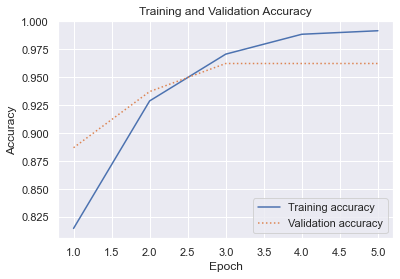

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

### Try to do it as before

Comment faire àpd nn.Sequential ??

In [53]:
X_train = torch.from_numpy(training_padded).float()
X_test = torch.from_numpy(testing_padded).float()
Y_train = torch.from_numpy(train_labels).float()
Y_test = torch.from_numpy(test_labels).float()

In [54]:
net = nn.Sequential(
    nn.Embedding(vocab_size, 32), #input_length = max_len),
    nn.Flatten(),
    nn.Linear(max_len, 128),
    nn.ReLU(),
    #nn.Linear(128, 128),
    #nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)
net

Sequential(
  (0): Embedding(500, 32)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=50, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
  (5): Sigmoid()
)

In [55]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=.01)

loss_history = [] #Per epoch
accuracy_history = []
accuracy_test_history = []

for i in range(iters):
    proba_pred = net(X_train)  # forward pass
    proba_pred = proba_pred.squeeze(-1)  # transform the 1-element vectors into scalars

    optimizer.zero_grad() # reset the gradients to 0
    loss = criterion(proba_pred, Y_train)
    loss_history.append(loss.item()) # .item() to turn it into a python number
    loss.backward()  # obtain the gradients with respect to the loss
    optimizer.step()  # perform one step of gradient descent

    with torch.no_grad():
        Y_pred = proba_pred > 0.5  # Binary label
        accuracy = (Y_train == Y_pred).float().mean()
        accuracy_history.append(accuracy.item())
            
    with torch.no_grad():
        proba_pred_test = net(X_test)
        proba_pred_test = proba_pred_test.squeeze(-1)
        Y_pred_test = proba_pred_test > 0.5
        accuracy_test = (Y_test == Y_pred_test).float().mean()
        accuracy_test_history.append(accuracy_test.item())
    
    print("Iteration {iter} done".format(iter=i+1))
    print("Training accuracy is equal to {trainAcc}".format(trainAcc=accuracy_history[-1]))
    print("Testing accuracy is equal to {testAcc}".format(testAcc=accuracy_test))

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

### TextVectorization

In [137]:
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf

model = Sequential()
model.add(InputLayer(input_shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=vocab_size, output_sequence_length=max_len))
model.add(Embedding(vocab_size, 32, input_length=max_len))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, 50)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 50, 32)            16000     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 221,057
Trainable params: 221,057
Non-trainable params: 0
_________________________________________________________________


In [112]:
model.predict(['Why pay more for expensive meds when you can order them online and save $$$?'])[0][0]

0.5125024

In [125]:
messages.message[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [127]:
model.predict([messages.message[0]])[0][0]

0.51352453

Pourquoi l'entraînement ne marche pas ?

In [134]:
hist = model.fit(msg_df.message, msg_df.label, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5


TypeError: 'NoneType' object is not callable

### Word2Vec

Utilisation en pratique ?

In [70]:
# import torch.autogradtorch.aut as autograd
# torch.autograd.grad

class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, context_word):
        emb = self.embeddings(context_word)
        hidden = self.linear(emb)
        out = F.log_softmax(hidden)
        return out

In [78]:
Word2Vec(2, 500)

Word2Vec(
  (embeddings): Embedding(500, 2)
  (linear): Linear(in_features=2, out_features=500, bias=True)
)

In [136]:
vocabulary_size = vocab_size
net = Word2Vec(embedding_size = 2, vocab_size = vocabulary_size)
loss_function = nn.BCELoss()
optimizer = optim.Adam(net.parameters())
context_tensor_list = []

for i in range(len(training_padded)):
    target_tensor = torch.autograd.Variable(torch.LongTensor([train_labels]))
    context_tensor = torch.autograd.Variable(torch.LongTensor([training_padded]))
    context_tensor_list.append((target_tensor, context_tensor))
    
while True:
    losses = []
    #for i in range(len(training_padded)):
    for target_tensor, context_tensor in context_tensor_list:
        net.zero_grad()
        log_probs = net(context_tensor)
        loss = loss_function(log_probs, target_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", np.mean(losses))

C:\Users\remac\AppData\Local\Temp\ipykernel_11688\4075335543.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(hidden)


ValueError: Using a target size (torch.Size([1, 1195])) that is different to the input size (torch.Size([1, 1195, 50, 500])) is deprecated. Please ensure they have the same size.